### Modelización y proyección de la potencia solar instalada (PNIEC)

Este código construye el histórico anual de potencia solar hasta 2023, proyecta la potencia instalada para 2024–2030 mediante un modelo cuadrático alineado con el PNIEC, genera una serie diaria con valor constante por año y visualiza conjuntamente el histórico y la proyección.

=== HISTÓRICO (hasta 2023) ===
Año 2019: 6.45 GW
Año 2020: 10.60 GW
Año 2021: 12.78 GW
Año 2022: 16.43 GW
Año 2023: 20.59 GW

=== PROYECCIÓN (2024–2030) ===
Año 2024: 21.72 GW
Año 2025: 25.11 GW
Año 2026: 30.77 GW
Año 2027: 38.68 GW
Año 2028: 48.86 GW
Año 2029: 61.3 GW
Año 2030: 76.0 GW


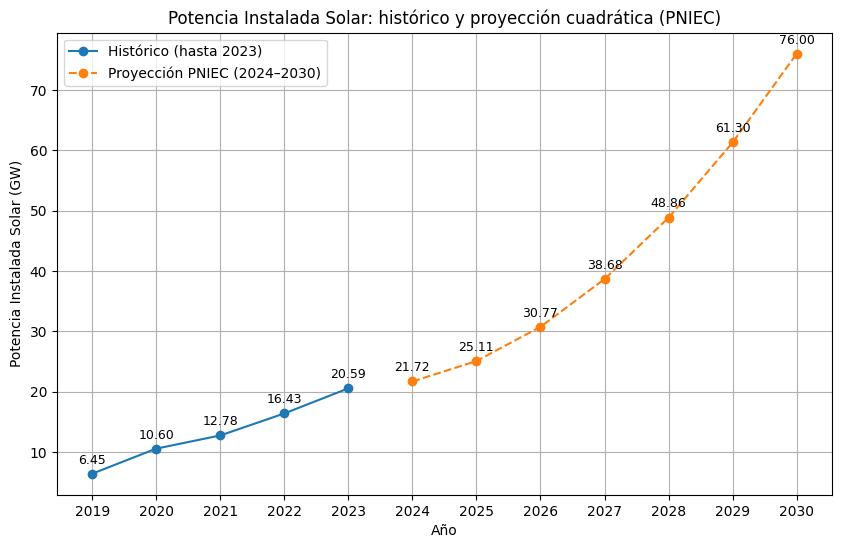

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargamos y preparamos los datos de histórico

df = pd.read_csv("../../SET_INPUTS_BASE_0.csv")

df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

# Eliminamos 29 de febrero
df = df[~((df["Date"].dt.month == 2) & (df["Date"].dt.day == 29))]

# Histórico anual hasta 2023
pot_hist_anual = (
    df[df["Year"] <= 2023]
    .groupby("Year", as_index=False)["Pot_Solar_GW"]
    .first()
)


# Proyección anual (MODELO CUADRÁTICO PNIEC)

years = np.arange(2023, 2031)
t = years - 2023

P0 = 20.59   # GW en 2023
P7 = 76.0    # GW para el 2030

a = (P7 - P0) / 7**2
c = P0

potencia = np.round(a * t**2 + c, 2)

df_proyeccion = pd.DataFrame({
    "Year": years,
    "Pot_Solar_GW": potencia
})

df_fut = df_proyeccion[df_proyeccion["Year"] >= 2024]


# Proyección diaria (VALOR CONSTANTE POR AÑO)

df_pot_solar_2030 = (
    df_fut
    .assign(key=1)
    .merge(
        pd.DataFrame({
            "Date": pd.date_range("2024-01-01", "2030-12-31", freq="D")
        }).assign(key=1),
        on="key"
    )
    .query("Date.dt.year == Year")
    .assign(
        Month=lambda x: x["Date"].dt.month,
        Day=lambda x: x["Date"].dt.day
    )
    [["Year", "Month", "Day", "Pot_Solar_GW"]]
)

df_pot_solar_2030.to_csv("pot_solar_diario_2024_2030.csv", index=False)

print("=== HISTÓRICO (hasta 2023) ===")
for _, row in pot_hist_anual.iterrows():
    print(f"Año {int(row['Year'])}: {row['Pot_Solar_GW']:.2f} GW")

print("\n=== PROYECCIÓN (2024–2030) ===")
for _, row in df_fut.iterrows():
    print(f"Año {int(row['Year'])}: {row['Pot_Solar_GW']} GW")



# Gráfica histórico y proyección

plt.figure(figsize=(10, 6))
offset = 1.2  # separación vertical en GW

plt.plot(
    pot_hist_anual["Year"],
    pot_hist_anual["Pot_Solar_GW"],
    marker="o",
    label="Histórico (hasta 2023)"
)
# Valores sobre puntos históricos (solo 2 decimales)
for x, y in zip(pot_hist_anual["Year"], pot_hist_anual["Pot_Solar_GW"]):
    plt.text(x, y + offset, f"{y:.2f}", ha="center", va="bottom", fontsize=9)

plt.plot(
    df_fut["Year"],
    df_fut["Pot_Solar_GW"],
    marker="o",
    linestyle="--",
    label="Proyección PNIEC (2024–2030)"
)
# Valores sobre puntos de proyección
for x, y in zip(df_fut["Year"], df_fut["Pot_Solar_GW"]):
    plt.text(x, y + offset, f"{y:.2f}", ha="center", va="bottom", fontsize=9)


plt.xlabel("Año")
plt.ylabel("Potencia Instalada Solar (GW)")
plt.title("Potencia Instalada Solar: histórico y proyección cuadrática (PNIEC)")
plt.grid(True)
plt.legend()

plt.xticks(range(
    pot_hist_anual["Year"].min(),
    df_fut["Year"].max() + 1
))

plt.show()